In [7]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# ml
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import pandas as pd

In [8]:
print(tf.__version__)

2.2.0


In [12]:
class StockPredictor():
    
    hist_start   = '2010-01-01'
    sequence_len = 60
    epoch        = 10
    batch_size   = 30
    
    def __init__(self, ticker_sym):
        self.ticker = yf.Ticker(ticker_sym)
        self.ticker_df, self.train_data, self.test_data = self.fetch_ticker_data()
        self.model = Sequential()
        
    # fetch_ticker_data
    # get data from hist_start -> today
    # scale and split to train/test set
    def fetch_ticker_data(self):
        
        # step 1 - fetch data
        hist_end = datetime.datetime.today().strftime('%Y-%m-%d')
        ticker_df = self.ticker.history(interval='1d', start=self.hist_start, end=hist_end)
        
        # step 2 - clean data
        ticker_df = ticker_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1)
        ticker_df.dropna()
        
        # step 3 - scale
        scaler = MinMaxScaler()
        ticker_scaled = scaler.fit_transform(ticker_df)

        ticker_df['Open']  = ticker_scaled[:,0]
        ticker_df['High']  = ticker_scaled[:,1]
        ticker_df['Low']   = ticker_scaled[:,2]
        ticker_df['Close'] = ticker_scaled[:,3]
        
        # step 4 - split data
        train_data, test_data = train_test_split(ticker_df, shuffle=False)
                
        return ticker_df, np.array(train_data), np.array(test_data)
    
    # sequence_data
    # running window of sequences to format data
    # as input to the rnn
    # data = [0 - sequence_len-1]
    #        [1 - sequence_len-2]
    #        ...................
    @staticmethod
    def sequence_data(series_data, sequence_len):
        X = []
        y = []
        
        for i in range(sequence_len, series_data.shape[0]):
            X.append(series_data[i-sequence_len:i])
            y.append(series_data[i, 0])

        return np.array(X), np.array(y)
        
        
    # train    
    def train(self):

        # step 1 - sequence data
        X_train, y_train = StockPredictor.sequence_data(self.train_data, self.sequence_len)
        
        # step 2 - build model
        self.build_model( (X_train.shape[1],X_train.shape[2]) )

        # step 3 - fit
        self.model.fit(X_train, y_train, epochs=self.epoch, batch_size=self.batch_size)
        
        
    # test
    # 
    def test(self):
        
        # step 1 - sequence data
        X_test, y_test = StockPredictor.sequence_data(self.test_data, self.sequence_len)
        
        # step 2 - predict
        pred = self.model.predict(X_test)
        
        # step 3 - evaluate
        snrdB = 10*np.log10(np.sum(np.square( pred[:,59] - y_test ))/np.sum(np.square(y_test)))
 
        return snrdB
    
    
    # build_model
    # construct the model
    def build_model(self, input_shape):

        # input layer
        self.model.add(LSTM(units=self.sequence_len, activation='relu', return_sequences=True, input_shape = input_shape))
        self.model.add(Dropout(0.2))

        # hidden layer
        self.model.add(LSTM(units=120, activation='relu', return_sequences=True))
        self.model.add(Dropout(0.6))

        # hidden 2
        self.model.add(LSTM(units=80, activation='relu', return_sequences=True))
        self.model.add(Dropout(0.2))
        
        # output
        self.model.add(Dense(1))
        self.model.build()
        
        # spit a summary
        self.model.summary()
        
        # optimizer and loss function
        self.model.compile(optimizer='adam', loss='mean_squared_error')
    
    
    # predict
    # predict the value on given date
    def predict(self, date):
        
        # step 1 - get sequence data ( date - sequence_len -> date )
        sequence_data = self.ticker_df[:date].iloc[-self.sequence_len-1:-1]
        
        # step 2 - load sequence data and predict
        pred = regressor.predict(np.expand_dims(sequence_data, axis=0))
        
        return pred


In [13]:
# example usage
s = StockPredictor('aapl')
s.train()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 60)            15600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 120)           86880     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 80)            64320     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)            

In [11]:
s.test()

19.107199092049697

# 1. data

In [3]:
# get stock data for ticker
ticker = yf.Ticker('aapl')

start ='2010-01-01'
end   = datetime.datetime.today().strftime('%Y-%m-%d')

ticker_df = ticker.history(interval='1d', start=start, end=end)

In [4]:
ticker_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31,26.36,26.39,26.04,26.06,88102700,0.0,0.0
2010-01-04,26.40,26.53,26.27,26.47,123432400,0.0,0.0
2010-01-05,26.54,26.66,26.37,26.51,150476200,0.0,0.0
2010-01-06,26.51,26.62,26.06,26.09,138040000,0.0,0.0
2010-01-07,26.19,26.22,25.85,26.04,119282800,0.0,0.0


In [5]:
ticker_df = ticker_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1)

In [6]:
# check for nulls
ticker_df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [7]:
ticker_df.dropna()

,Open,High,Low,Close
Date,,,,
2009-12-31,26.36,26.39,26.04,26.06
2010-01-04,26.40,26.53,26.27,26.47
2010-01-05,26.54,26.66,26.37,26.51
2010-01-06,26.51,26.62,26.06,26.09
2010-01-07,26.19,26.22,25.85,26.04
...,...,...,...,...
2020-07-13,389.06,399.82,381.03,381.91
2020-07-14,379.36,389.02,375.51,388.23
2020-07-15,395.96,396.99,385.96,390.90


Text(0.5, 1.0, 'Apple stock history')

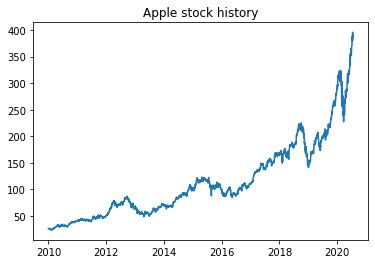

In [8]:
# visualise
plt.plot(ticker_df['Open'])
plt.title('Apple stock history')

In [9]:
# scale
scaler = MinMaxScaler()

ticker_scaled = scaler.fit_transform(ticker_df)

ticker_df['Open']  = ticker_scaled[:,0]
ticker_df['High']  = ticker_scaled[:,1]
ticker_df['Low']   = ticker_scaled[:,2]
ticker_df['Close'] = ticker_scaled[:,3]

In [10]:
# train/test split
train_data, test_data = train_test_split(ticker_df, shuffle=False)
train_data = np.array(train_data)
test_data  = np.array(test_data)

In [11]:
# train and test data

X_train = []
y_train = []

for i in range(60, train_data.shape[0]):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')

X_train.shape = (1930, 60, 4)
y_train.shape = (1930,)


# 2. Model

In [13]:
model = Sequential()

model.add(LSTM(units=60, activation='relu', return_sequences=True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(1))
model.build()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            15600     
_________________________________________________________________
dropout (Dropout)            (None, 60, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
dense (Dense)                (None, 60, 1)             81        
Total params: 60,801
Trainable params: 60,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. train

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=30)

Epoch 1/10
65/65 [==============================] - 7s 107ms/step - loss: 0.0047
Epoch 2/10
65/65 [==============================] - 6s 100ms/step - loss: 0.0014
Epoch 3/10
65/65 [==============================] - 7s 102ms/step - loss: 0.0012
Epoch 4/10
65/65 [==============================] - 6s 98ms/step - loss: 0.0010
Epoch 5/10
65/65 [==============================] - 8s 126ms/step - loss: 9.0590e-04
Epoch 6/10
65/65 [==============================] - 9s 134ms/step - loss: 8.4067e-04
Epoch 7/10
65/65 [==============================] - 7s 104ms/step - loss: 7.5024e-04
Epoch 8/10
65/65 [==============================] - 7s 112ms/step - loss: 7.1254e-04
Epoch 9/10
65/65 [==============================] - 7s 103ms/step - loss: 6.5785e-04
Epoch 10/10
65/65 [==============================] - 6s 92ms/step - loss: 6.3733e-04


Text(0.5, 1.0, 'train data')

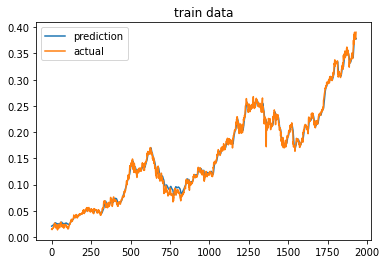

In [17]:
pred = model.predict(X_train)
plt.plot(pred[:,59])
plt.plot(y_train)
plt.legend(['prediction', 'actual'])
plt.title('train data')

# 4. evaluate

In [18]:
# evaluate on test data
test_data = scaler.fit_transform(ticker_df['2019-01-01':])
test_data.shape

(389, 4)

In [19]:
X_test = []
y_test = []
for i in range(60, test_data.shape[0]):
    X_test.append(test_data[i-60:i])
    y_test.append(test_data[i, 0])
    
X_test = np.array(X_test)
y_test = np.array(y_test)

Text(0.5, 1.0, 'train data')

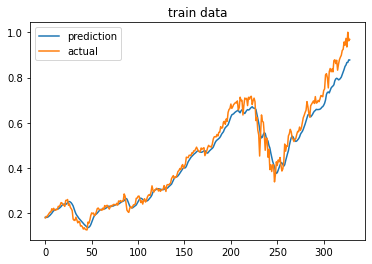

In [20]:
pred = model.predict(X_test)
plt.plot(pred[:,-1])
plt.plot(y_test)
plt.legend(['prediction', 'actual'])
plt.title('train data')

In [21]:
# metrics
snr = 10*np.log10(np.sum(np.square( pred[:,59] - y_test ))/np.sum(np.square(y_test)))
snr

20.557432570598255

In [22]:
# evaluate on test data
test_data = scaler.fit_transform(ticker_df['2019-01-01':])
test_data.shape

(389, 4)

In [23]:
date = '2020-07-14'
sequence_data = ticker_df[:date].iloc[-60-1:-1]

In [47]:
np.expand_dims(sequence_data, axis=0)

(1, 60, 4)

In [48]:
pred = model.predict(np.expand_dims(sequence_data, axis=0))
pred[0,-1]

array([0.8722066], dtype=float32)